In [ ]:
#https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349
#very good reference

In [85]:
import pandas as pd
import numpy as np

In [42]:
df_master=pd.read_csv("df_master.csv", index_col=0)

In [43]:
df_master.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume,percentage,z-score,Label,...,Gain,Loss,AVG_Gain,AVG_Loss,RS,RSI,obv,VAO,Positive,VolumePositive
0,2008-09-17,11056.58,11057.31,10595.90,10609.66,10609.66,463200000.0,-0.040633,-3.403907,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-1.004889e+11,False,False
1,2008-09-18,10609.01,11076.44,10459.44,11019.69,11019.69,488060000.0,0.038647,-1.564634,1.0,...,410.03,0.00,NaN,NaN,NaN,NaN,4.880600e+08,1.228691e+11,True,True
2,2008-09-19,11027.51,11483.05,11026.70,11388.44,11388.44,655110000.0,0.033463,0.011810,1.0,...,368.75,0.00,NaN,NaN,NaN,NaN,1.143170e+09,8.749977e+10,True,True
3,2008-09-22,11394.42,11394.58,10992.20,11015.69,11015.69,213210000.0,-0.032731,-1.549244,0.0,...,0.00,372.75,NaN,NaN,NaN,NaN,9.299600e+08,-3.788742e+10,False,False
4,2008-09-23,11015.69,11143.21,10833.94,10854.17,10854.17,204480000.0,-0.014663,-2.108707,0.0,...,0.00,161.52,NaN,NaN,NaN,NaN,7.254800e+08,-2.748313e+10,False,False


In [44]:
df_master.columns

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume',
       'percentage', 'z-score', 'Label', 'significance', 'sentiment', '30_SMA',
       '50_SMA', '200_SMA', 'EMA', 'Upper Bollinger Band',
       'Lower Bollinger Band', 'stoch_k', 'stoch_d', 'Gain', 'Loss',
       'AVG_Gain', 'AVG_Loss', 'RS', 'RSI', 'obv', 'VAO', 'Positive',
       'VolumePositive'],
      dtype='object')

In [10]:
#30_SMA, #50_SMA, #200_SMA, #EMA, #Upper Bollinger Band, #Lower Bollinger Band, #stoch_k, #stoch_d, #RSI, #obv,#VAO
#significance #sentiment => #percentage as the y-axis

In [45]:
df_master.columns

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume',
       'percentage', 'z-score', 'Label', 'significance', 'sentiment', '30_SMA',
       '50_SMA', '200_SMA', 'EMA', 'Upper Bollinger Band',
       'Lower Bollinger Band', 'stoch_k', 'stoch_d', 'Gain', 'Loss',
       'AVG_Gain', 'AVG_Loss', 'RS', 'RSI', 'obv', 'VAO', 'Positive',
       'VolumePositive'],
      dtype='object')

In [46]:
df_master.head()
df_master['percentage_yesterday']=df_master['percentage']

In [47]:
# lets first shifting
mask = ~(df_master.columns.isin(['Date','Open', 'High', 'Low', 'Close*', 'Adj Close**', 'percentage']))

cols_to_shift = df_master.columns[mask]

df_master[cols_to_shift] = df_master.loc[:,mask].shift(1)


In [48]:
df_master.head() #look at the positive columsn, we are using yesterday's information

,Date,Open,High,Low,Close*,Adj Close**,Volume,percentage,z-score,Label,...,Loss,AVG_Gain,AVG_Loss,RS,RSI,obv,VAO,Positive,VolumePositive,percentage_yesterday
0,2008-09-17,11056.58,11057.31,10595.90,10609.66,10609.66,NaN,-0.040633,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-09-18,10609.01,11076.44,10459.44,11019.69,11019.69,463200000.0,0.038647,-3.403907,0.0,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-1.004889e+11,False,False,-0.040633
2,2008-09-19,11027.51,11483.05,11026.70,11388.44,11388.44,488060000.0,0.033463,-1.564634,1.0,...,0.00,NaN,NaN,NaN,NaN,4.880600e+08,1.228691e+11,True,True,0.038647
3,2008-09-22,11394.42,11394.58,10992.20,11015.69,11015.69,655110000.0,-0.032731,0.011810,1.0,...,0.00,NaN,NaN,NaN,NaN,1.143170e+09,8.749977e+10,True,True,0.033463
4,2008-09-23,11015.69,11143.21,10833.94,10854.17,10854.17,213210000.0,-0.014663,-1.549244,0.0,...,372.75,NaN,NaN,NaN,NaN,9.299600e+08,-3.788742e+10,False,False,-0.032731


# XGBoost Regression

In [57]:
import xgboost as xgb

In [58]:
model=xgb.XGBRegressor()

In [33]:
from sklearn.model_selection import train_test_split


In [60]:
X=df_master[['significance', 'sentiment', '30_SMA', '50_SMA', '200_SMA', 'EMA', 'Upper Bollinger Band', 'Lower Bollinger Band', 'stoch_k', 'stoch_d', 'RSI', 'obv', 'VAO', 'percentage_yesterday']]

In [62]:
y=df_master[['percentage']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 99)

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1371 entries, 258 to 641
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   significance          1370 non-null   float64
 1   sentiment             1370 non-null   float64
 2   30_SMA                1370 non-null   float64
 3   50_SMA                1370 non-null   float64
 4   200_SMA               1370 non-null   float64
 5   EMA                   1238 non-null   float64
 6   Upper Bollinger Band  1340 non-null   float64
 7   Lower Bollinger Band  1340 non-null   float64
 8   stoch_k               1238 non-null   float64
 9   stoch_d               1205 non-null   float64
 10  RSI                   1339 non-null   float64
 11  obv                   1370 non-null   float64
 12  VAO                   1370 non-null   float64
 13  percentage_yesterday  1370 non-null   float64
dtypes: float64(14)
memory usage: 160.7 KB


In [65]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 1299 to 338
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   significance          588 non-null    float64
 1   sentiment             588 non-null    float64
 2   30_SMA                588 non-null    float64
 3   50_SMA                588 non-null    float64
 4   200_SMA               588 non-null    float64
 5   EMA                   521 non-null    float64
 6   Upper Bollinger Band  569 non-null    float64
 7   Lower Bollinger Band  569 non-null    float64
 8   stoch_k               521 non-null    float64
 9   stoch_d               505 non-null    float64
 10  RSI                   569 non-null    float64
 11  obv                   588 non-null    float64
 12  VAO                   588 non-null    float64
 13  percentage_yesterday  588 non-null    float64
dtypes: float64(14)
memory usage: 68.9 KB


In [110]:
train_matrix=xgb.DMatrix(data=X_train, label=y_train)
test_matrix=xgb.DMatrix(data=X_test, label=y_test)

In [111]:
reg_params =  [1, 10, 100]


In [112]:
params = {"objective": "reg:squarederror"}


In [113]:
# Create an empty list for storing rmses as a function of ridge regression complexity
ridge_regression = []


In [114]:
# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg

    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=train_matrix, params=params, nfold=5, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

    # Append best rmse (final round)
    ridge_regression.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])



In [115]:
ridge_regression

[0.08515110830595381, 0.08662948160601361, 0.10095289484464469]

In [116]:
print("Best RMSE as a function of ridge regression (L2 regularization):")
print(pd.DataFrame(list(zip(reg_params, ridge_regression)), columns=["l2", "rmse"]))


Best RMSE as a function of ridge regression (L2 regularization):
    l2      rmse
0    1  0.085151
1   10  0.086629
2  100  0.100953


In [117]:
# gets pick the best model
params = {"objective": "reg:squarederror", 
         "lambda": "1"}

bst = xgb.train(dtrain=train_matrix, params=params, num_boost_round=50)




In [122]:
prediction=bst.predict(test_matrix)

In [128]:
from sklearn.metrics import mean_squared_error
print((mean_squared_error(prediction, y_test, squared=False)))


0.014899095408533965


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

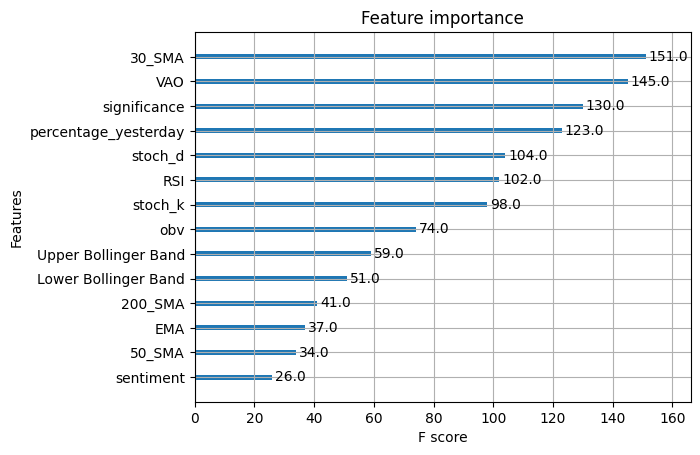

In [132]:
xgb.plot_importance(bst)


## Grid Search ##

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [137]:
grid_search_params = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [100],
    'subsample': [0.2, 0.5, 0.8],
    'max_depth': [2, 3, 5]
}


In [138]:
xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")


In [139]:
grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=4, verbose=1)


In [83]:
grid.fit(X, y)


Fitting 4 folds for each of 72 candidates, totalling 288 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [2, 3, 5], 'n_estimators': [100],
                         'subsample': [0.2, 0.5, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [140]:
grid


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [2, 3, 5], 'n_estimators': [100],
                         'subsample': [0.2, 0.5, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [86]:
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))



Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.2}
Lowest RMSE found:  0.014184689588473008


In [144]:
# gets pick the best model, no need for nestimators
params = {"objective": "reg:squarederror", 
         'colsample_bytree': 0.7, 
          'learning_rate': 0.1, 
          'max_depth': 2, 
          'subsample': 0.2
         }

bst_grid = xgb.train(dtrain=train_matrix, params=params, num_boost_round=50)


In [146]:
grid_prediction=bst.predict(test_matrix)

In [147]:
print((mean_squared_error(grid_prediction, y_test, squared=False)))


0.013244303370027789


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

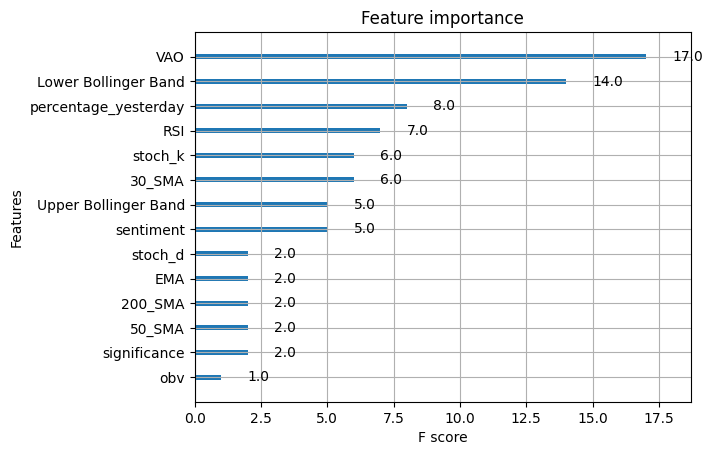

In [148]:
xgb.plot_importance(bst_grid)


## Random Search Parameters


In [92]:
params_random_search = {
    'learning_rate': np.arange(0.01, 1.01, 0.01),
    'n_estimators': [50, 100, 200],
    'max_depth': range(2, 12),
    'subsample': np.arange(0.02, 1.02, 0.02),
    'colsample_bytree': [0.3, 0.5, 0.7,1],

}


In [93]:
xg_random_reg = xgb.XGBRegressor(objective= "reg:squarederror")
    

In [95]:
randomized_mse = RandomizedSearchCV(param_distributions=params_random_search, estimator=xg_random_reg,
                                    scoring="neg_mean_squared_error", n_iter=5, cv=4, verbose=1)


In [96]:
randomized_mse.fit(X, y)


Fitting 4 folds for each of 5 candidates, totalling 20 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'max_depth': range(2, 12),
                                        'n_estimators': [50, 100, 200],
                                        'subsample': array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=1)

In [97]:
print("Randomize Search Cross Validation")
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))


Randomize Search Cross Validation
Best parameters found:  {'subsample': 0.30000000000000004, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.17, 'colsample_bytree': 0.7}
Lowest RMSE found:  0.014263644478661285


In [149]:
# gets pick the best model, no need for nestimators
params = {"objective": "reg:squarederror", 
         'subsample': 0.30000000000000004,  'max_depth': 6, 'learning_rate': 0.17, 'colsample_bytree': 0.7
         }

bst_random = xgb.train(dtrain=train_matrix, params=params, num_boost_round=50)

In [150]:
random_prediction=bst_random.predict(test_matrix)

In [151]:
print((mean_squared_error(random_prediction, y_test, squared=False)))


0.014682185781206133


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

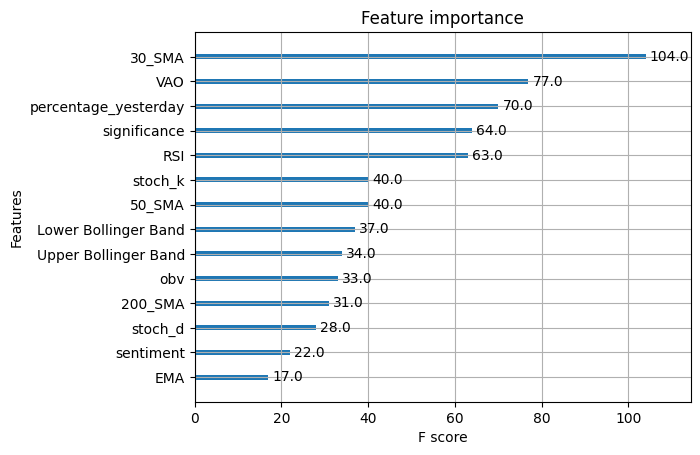

In [152]:
xgb.plot_importance(bst_random)